This notebook demonstrates the application of AlphaBuilding ResCommunity by reproducing the work of *Hao, H., Sanandaji, B.M., Poolla, K. and Vincent, T.L., 2014. Aggregate flexibility of thermostatically controlled loads. IEEE Transactions on Power Systems, 30(1), pp.189-198*

Replace the variable *PATH_TO_ROOT* to run the notebook

In [1]:
import sys

PATH_TO_ROOT = 'C:/Users/walter/Desktop/git/AlphaBuilding-ResCommunity'
sys.path.insert(0,PATH_TO_ROOT)

In [2]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt

from pykalman import KalmanFilter

from gym_AlphaBuilding.envs import residential
from util.distribution import utility
from util.weather import noaa_weather

import matplotlib.ticker as mtick

In [3]:
plt.rc('xtick', labelsize=14, color='grey')
plt.rc('ytick', labelsize=14, color='grey')
plt.rc('axes', titlesize=22)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('legend', fontsize=16, title_fontsize=20)
plt.rc('savefig', dpi=330, bbox='tight')

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
def generate_fig_name(fig_name):
    '''
    Generate the figure path and name
    To be used by plt.savefig function
    '''
    return '{}/docs/fig/{}'.format(PATH_TO_ROOT, fig_name)

## Prepare the environment

In [5]:
# Specify the environment parameters
city = 'Berkeley'
state = 'CA'

start_date = date(2020,8,14)
final_date = date(2020,8,15)

SAMPLE_SIZE = 1000
STEP_SIZE = 5 # min
sim_horizon = (str(start_date), str(final_date))

In [6]:
# Download weather data from NOAA weather stations
# If you want to use your own weather data, skip this step
address = '{}, {}'.format(city, state)
station_ids, station_names = noaa_weather.find_closest_weather_station(noaa_weather.geocode_address(address))

# You might need to try a couple of weather stations, because some weather stations have large missing rate 
weather = noaa_weather.download_weather(station_ids[0], start_date.year)
weather = weather.tz_convert('America/Los_Angeles').tz_localize(None)  # remove tz-awareness

# truncate and resample the weather data to fit the simulation horizon and time step
weather_h = weather.resample('1H').mean()  # hourlu average to remove noise
weather_ts = weather_h.resample('{}min'.format(STEP_SIZE)).interpolate()
weather_ts = weather_ts.truncate(start_date, final_date+timedelta(days=1))

In [7]:
# Retrieve the parameters
ttc = utility.get_ttc(state)
teq = utility.get_teq(state)
tsp, trange = utility.get_comfort_temp('cooling', 'ASHRAE PMV')

In [8]:
np.random.seed(1)

env = residential.AlphaResEnv(sampleSize  = SAMPLE_SIZE, 
                           stepSize    = STEP_SIZE, 
                           simHorizon  = sim_horizon,
                           ambientWeather = weather_ts, 
                           ttc = ttc, 
                           teq = teq, 
                           tsp = tsp, 
                           trange = trange,
                           hvacMode = 'cooling only',
                           measurementErrorSigma = 0.2)

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [9]:
env_parameters = env.getParameters()

## Tracking target

In [10]:
from scipy.interpolate import UnivariateSpline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def input_renewable(date):
    '''
    date: the date of renewable to be tracked, example '2020-07-01'
    '''
    date_formatted = ''.join(date.split('-'))
    try:
        supply = pd.read_csv('{}/data/CAISO_supply/CAISO-supply-{}.csv'.format(PATH_TO_ROOT, date_formatted),
                            index_col=0)
    except:
        raise IOError('Date {} is not available. Please download from http://www.caiso.com/TodaysOutlook/Pages/supply.aspx \
        and save it to the repository "data/CAISO_supply/"'.format(date))
    
    supply = pd.DataFrame(supply.values.T, index=supply.columns, columns=supply.index)
    supply.dropna(inplace=True)
    renewable = supply['Renewables'].values
    
    return renewable


def renewable_regulation_target(renewable, smooth_window=12):
    smooth_func = UnivariateSpline(np.arange(smooth_window/2, len(renewable), smooth_window), 
                                   renewable[int(smooth_window/2)::smooth_window])
    step_index= np.arange(len(renewable))
    smoothed = smooth_func(step_index)
    regulation_target = renewable - smoothed
    return regulation_target, smoothed


def base_load(weather_ts, teq, env_parameters, otherHG_ratio=0.6):
    temp_amb = (weather_ts['Temperature'].values+teq[0]*otherHG_ratio)[:, np.newaxis]
    temp_diff = temp_amb - env_parameters['T_sp'].values[np.newaxis, :]
    p_base_individial = temp_diff/((env_parameters['R']*env_parameters['COP_c']).values[np.newaxis, :])
    p_base = p_base_individial.sum(axis=1)   # unit kW
    return p_base


def tracking_target(start_date, weather_ts, env_parameters, teq, scale_factor):
    # match the time index of weather data and renewable data
    renewable_data = input_renewable(str(start_date))
    renewable = pd.DataFrame(data=renewable_data, columns=['Renewable'])
    renewable.index = pd.date_range(start_date, final_date, periods=len(renewable)+1)[:len(renewable)]

    data = pd.concat([weather_ts, renewable], axis=1)
    data.interpolate(method='linear', inplace=True)
    
    # generate the regulation target
    step_per_hour = (len(data)-1)/24
    regulation_target, smoothed = renewable_regulation_target(data['Renewable'].values, smooth_window=int(step_per_hour))
    regulation_target_normalized = regulation_target/max(abs(regulation_target))
    
    # base load
    p_base = base_load(data, teq, env_parameters)
    
    # combine the base load the regulation target
    p_target = regulation_target_normalized * env_parameters['P_c'].sum() * scale_factor + p_base
    p_target = p_target.clip(0,)
    
    return p_target, data, smoothed, regulation_target_normalized, p_base

In [11]:
p_target, data, smoothed, regulation_target_normalized, p_base = \
    tracking_target(start_date, weather_ts[:24*12], env_parameters, teq, scale_factor=0.15)

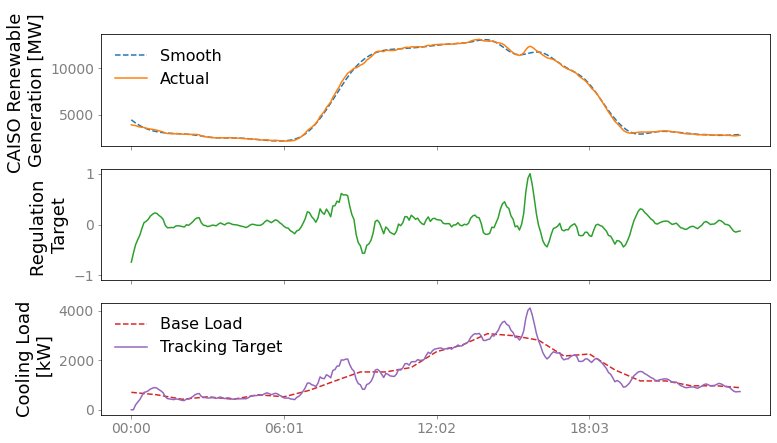

In [12]:
# plot
fig, axes = plt.subplots(3, 1, figsize = (12, 7), sharex = 'all')

start_time = pd.to_datetime(start_date, format='%Y/%m/%d')
final_time = pd.to_datetime(final_date, format='%Y/%m/%d')
time_index = pd.date_range(start_time, final_time, periods=len(data))

axes[0].plot(time_index, smoothed, '--', color=default_colors[0], label = "Smooth")
axes[0].plot(time_index, data['Renewable'].values, color=default_colors[1], label = 'Actual')
axes[0].set_ylabel("CAISO Renewable \nGeneration [MW]")
axes[0].legend(loc='upper left', frameon = False)

axes[1].plot(time_index, regulation_target_normalized, color=default_colors[2])
axes[1].set_ylabel("Regulation \nTarget")
axes[1].set_ylim(-1.1,1.1)
axes[1].tick_params(axis='both', which='major')

axes[2].plot(time_index, p_base, '--',color=default_colors[3], label = 'Base Load')
axes[2].plot(time_index, p_target, color=default_colors[4], label = 'Tracking Target')
axes[2].set_ylabel("Cooling Load\n [kW]")
axes[2].legend(loc='upper left', frameon = False)

axes[2].set_xticks(time_index[::72])
myFmt = mdates.DateFormatter('%H:%M')
axes[2].xaxis.set_major_formatter(myFmt)
plt.savefig(generate_fig_name('tracking_target'))

In [13]:
def plot_household(Temp, Action, env, index, fig_name=False):
    '''Function to plot single household
    '''
    fig, axes = plt.subplots(3,1, figsize=(12, 7), sharex=True)

    time_index = Temp.index

    # subplot1: total cooling load
    q_c_coord = (Action.values * env_parameters['P_c'].values).sum(axis=1)
    axes[0].plot(time_index, p_target, '-.', color=default_colors[2], label='Tracking target')
    axes[0].plot(time_index, q_c_coord, color=default_colors[1], label='Total load')
    # axes[0].plot(time_index, q_c_coord-p_target, color=default_colors[1], label='Load tracking error')
    axes[0].set_ylabel('Total Cooling \nLoad [kWh]')
    axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

    # subplot2: ambient temperature
    axes[1].plot(time_index, weather_ts['Temperature'].values[:len(time_index)], color=default_colors[3], label='Ambient Temp.')
    # plot deadband
    t_lower = tsp[0] - trange[0]/2
    t_upper = tsp[0] + trange[0]/2
    axes[1].plot((time_index[0],time_index[-1]), (t_lower, t_lower), 'g--', label='Comfort range')
    axes[1].plot((time_index[0],time_index[-1]), (t_upper, t_upper), 'g--')
    # plot temperature
    axes[1].plot(time_index, Temp[index].values, 'grey', label='Indoor Temp.')
    axes[1].set_ylabel('Temperature\n[$^oC$]')
    axes[1].set_ylim(weather_ts['Temperature'].values.min()-1, weather_ts['Temperature'].values.max()+1)
    axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

    # subplot3: action
    axes[2].plot(time_index, Action[index].values, color=default_colors[0], label='Cooling status')
    axes[2].set_ylabel('Cooling\nAction')
    axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))
    axes[2].set_yticks([0, 1])
    axes[2].set_yticklabels(['Off', 'On'])

    axes[2].set_xlabel('Time')
    axes[2].set_xticks(time_index[::72])
    myFmt = mdates.DateFormatter('%H:%M')
    axes[2].xaxis.set_major_formatter(myFmt)
    
    if fig_name:
        plt.savefig(generate_fig_name('{}_{}'.format(fig_name, index)))    

## Shedding task

In [14]:
class controller_RBC():
    def __init__(self, t_lower, t_upper):
        self.t_lower = t_lower
        self.t_upper = t_upper
    
    def action(self, t, a=0):
        if t < self.t_lower:
            action = 0
        elif t > self.t_upper:
            action = 1    # 1 for cooling
        else:
            action = a
        return action

t_lower = tsp[0] - trange[0]/2
t_upper = tsp[0] + trange[0]/2
    
controller_RBC = controller_RBC(t_lower+0.5, t_upper-0.5)



def priority_coordinator(P, t_in, t_upper, action, env, task, mode='Cooling'):
    '''
    task: str, 'tracking' for load trakcing;
               'shedding' for load shedding;
    '''
    
    action_new = np.array(action)
    
    if mode == 'Cooling':
        action_array = np.array(action)   # 2 for cooling
    number_ON = (action_array>0).sum()

    # distance to the tracking goal
    P_cooling = env.getParameters()['P_c'].values
    load = action_array * P_cooling
    load_total = load.sum()
    tracking_target = load_total - P
    
    if tracking_target > 0:            # Select which TCL to be turned off
        reduction_target = tracking_target
        dist_to_upper = t_upper - t_in
        dist_to_upper_ON = np.where(action_array == 0, 0, dist_to_upper)   # Keep cooling on households only
        num_potential_TCLs = (dist_to_upper_ON>0.5).sum()      # To avoid frequent turn on/off, only turn off TCL when the temp.
                                                               # is more than 1 degC lower than the upper bound                
        for i in np.argsort(-dist_to_upper_ON)[:num_potential_TCLs]:  # Turn off the TCL that is farthest to the upper bound 
            if reduction_target <= 0:
                break
            else:
                action_new[i] = 0   # turn off cooling
                reduction_target -= load[i]
    elif (tracking_target < 0) and (task == 'tracking'):           # Select which TCL to be turned on
        increase_target = -tracking_target
        dist_to_lower = t_in - t_lower
        dist_to_lower_OFF = np.where(action_array == 1, 0, dist_to_lower)   # Keep cooling off households only
        num_potential_TCLs = (dist_to_lower_OFF>0.5).sum()      # To avoid frequent turn on/off, only turn off TCL when the temp.
                                                                # is more than 1 degC lower than the upper bound
        for i in np.argsort(-dist_to_lower_OFF)[:num_potential_TCLs]:  # Turn on the TCL that is farthest to the lower bound 
            if increase_target <= 0:
                break
            else:
                action_new[i] = 0   # turn off cooling
                increase_target -= load[i]    
        
    return action_new

def Override(action, t_in, Tsp, Trange):
    action[t_in > Tsp+0.9*Trange] = 1
    action[t_in < Tsp-0.9*Trange] = 0
    return action

In [15]:
# Simulate conventional RBC without coordination

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_in_conv = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_conv = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

for time in T_in_conv.index:
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_RBC.action(t_in[i], act_previous[i])
    obs,_,_,_ = env.step(np.array(action)*2)    # 2 for cooling
    T_in_conv.loc[time] = t_in
    Action_conv.loc[time] = action
    act_previous = action

Episode: 1
Total Energy Consumption (kWh)
30121.21152925386
Total Uncomfortable Degree Hours (K*h)
4445.876181235963


In [16]:
# Simulate priority-stack-based control 

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_in_coord_shedding = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_coord_shedding = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))

P_cap = 2400 # unit:kW

for time in T_in_coord_shedding.index:
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_RBC.action(t_in[i], act_previous[i])
    action_coordinator = priority_coordinator(P_cap, t_in, t_upper, action, env, 'shedding', mode='Cooling')
    action_override = Override(action_coordinator, t_in, env_parameters['T_sp'].values, env_parameters['T_range'].values)
    obs,_,_,_ = env.step(action_override*2)  # 2 for cooling
    T_in_coord_shedding.loc[time] = t_in
    Action_coord_shedding.loc[time] = action_override
    act_previous = action

Episode: 2
Total Energy Consumption (kWh)
29635.436824947403
Total Uncomfortable Degree Hours (K*h)
4397.10330967071


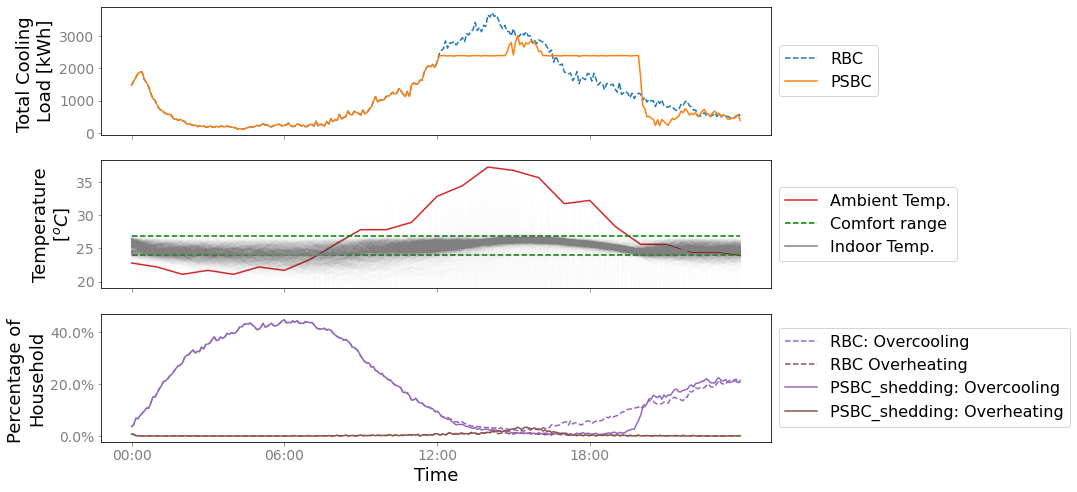

In [17]:
fig, axes = plt.subplots(3,1, figsize=(12, 8), sharex=True)

time_index = T_in_coord_shedding.index

# subplot0: total cooling load
q_c_conv = (Action_conv * env_parameters['P_c'].values).sum(axis=1)
q_c_coord = (Action_coord_shedding * env_parameters['P_c'].values).sum(axis=1)
axes[0].plot(time_index, q_c_conv, '--', label='RBC', color=default_colors[0])
axes[0].plot(time_index, q_c_coord, label='PSBC', color=default_colors[1])
axes[0].set_ylabel('Total Cooling \nLoad [kWh]')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot1: ambient and indoor temperature
axes[1].plot(time_index, weather_ts['Temperature'].values[:len(time_index)], color=default_colors[3], label='Ambient Temp.')
# plot deadband
axes[1].plot((time_index[0],time_index[-1]), (t_lower, t_lower), 'g--', label='Comfort range')
axes[1].plot((time_index[0],time_index[-1]), (t_upper, t_upper), 'g--')
# plot temperature
axes[1].plot(time_index, T_in_coord_shedding.values.mean(axis=1), 'grey', label='Indoor Temp.')
for columns in T_in_coord_shedding:
    axes[1].plot(time_index, T_in_coord_shedding[columns].values, 'grey', alpha=0.008)
axes[1].set_ylabel('Temperature\n[$^oC$]')
axes[1].set_ylim(weather_ts['Temperature'].values.min()-1, weather_ts['Temperature'].values.max()+1)
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot2: percentage of discomfort
overcooling_coord = (T_in_coord_shedding < t_lower).mean(axis=1).values
overheating_coord = (T_in_coord_shedding > t_upper).mean(axis=1).values
overcooling_conv = (T_in_conv < t_lower).mean(axis=1).values
overheating_conv = (T_in_conv > t_upper).mean(axis=1).values
axes[2].plot(time_index, overcooling_conv, '--',color=default_colors[4], label = 'RBC: Overcooling')
axes[2].plot(time_index, overheating_conv, '--',color=default_colors[5], label = 'RBC Overheating')
axes[2].plot(time_index, overcooling_coord, color=default_colors[4], label = 'PSBC_shedding: Overcooling')
axes[2].plot(time_index, overheating_coord, color=default_colors[5], label = 'PSBC_shedding: Overheating')
axes[2].set_ylabel('Percentage of \nHousehold')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].set_xlabel('Time')
axes[2].set_xticks(time_index[::72])
myFmt = mdates.DateFormatter('%H:%M')
axes[2].xaxis.set_major_formatter(myFmt)

plt.savefig(generate_fig_name('shedding'))

In [18]:
Action_coord_shedding

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
2020-08-14 00:00:00,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
2020-08-14 00:05:00,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2020-08-14 00:10:00,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2020-08-14 00:15:00,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
2020-08-14 00:20:00,0,0,0,0,1,0,0,0,0,1,...,0,1,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-14 23:35:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-14 23:40:00,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2020-08-14 23:45:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2020-08-14 23:50:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


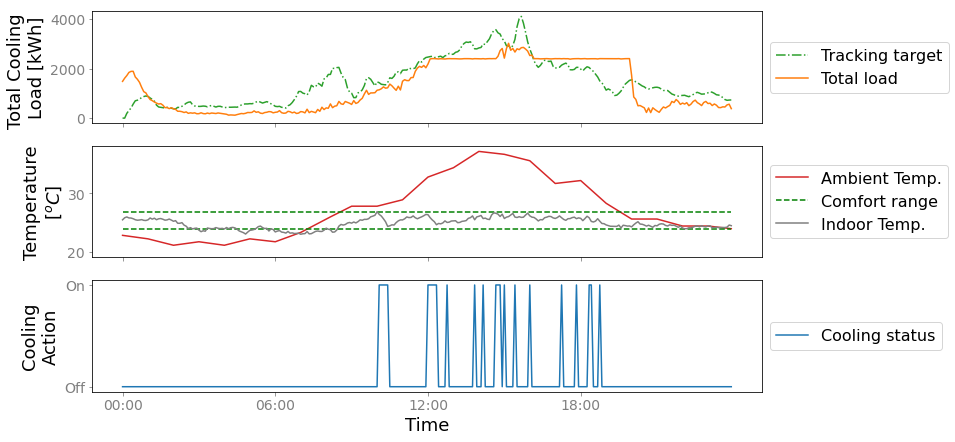

In [19]:
plot_household(T_in_coord_shedding, Action_coord_shedding, env, 3, 'psbc_shedding')

## Tracking task

In [20]:
# Simulate

np.random.seed(1)

obs = env.reset()
act_previous = [0]*SAMPLE_SIZE

T_in_coord_tracking = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
Action_coord_tracking = pd.DataFrame(index=env.t_index[:-1], columns = list(range(SAMPLE_SIZE)))
P_target = pd.DataFrame(data=p_target[:len(p_target)], index=env.t_index[:-1], columns=['Target'])  # unit:kW

for time in T_in_coord_tracking.index:
    p_tracking_target = P_target.loc[time,'Target']
    t_in = obs[-SAMPLE_SIZE:]
    t_amb = [obs[0]]*SAMPLE_SIZE
    action = [0]*SAMPLE_SIZE
    for i in range(SAMPLE_SIZE):
        action[i] = controller_RBC.action(t_in[i], act_previous[i])
    action_coordinator = priority_coordinator(p_tracking_target, t_in, t_upper, action, env, 'tracking',mode='Cooling')
    action_override = Override(action_coordinator, t_in, env_parameters['T_sp'].values, env_parameters['T_range'].values)
    obs,_,_,_ = env.step(action_override*2)
    T_in_coord_tracking.loc[time] = t_in
    Action_coord_tracking.loc[time] = action_override
    act_previous = action

Episode: 3
Total Energy Consumption (kWh)
29806.749510341935
Total Uncomfortable Degree Hours (K*h)
3806.832177098154


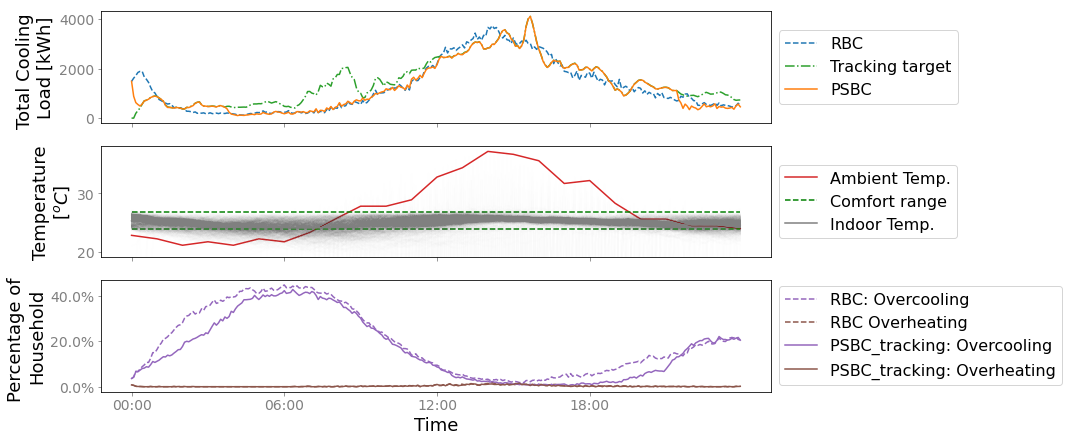

In [21]:
fig, axes = plt.subplots(3,1, figsize=(12, 7), sharex=True)

time_index = T_in_coord_tracking.index

# subplot1: total cooling load
q_c_conv = (Action_conv * env_parameters['P_c'].values).sum(axis=1)
q_c_coord = (Action_coord_tracking * env_parameters['P_c'].values).sum(axis=1)
axes[0].plot(time_index, q_c_conv, '--', color=default_colors[0], label='RBC')
axes[0].plot(time_index, P_target['Target'].values, '-.', color=default_colors[2], label='Tracking target')
axes[0].plot(time_index, q_c_coord, color=default_colors[1], label='PSBC')
axes[0].set_ylabel('Total Cooling \nLoad [kWh]')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot2: ambient temperature
axes[1].plot(time_index, weather_ts['Temperature'].values[:len(time_index)], color=default_colors[3], label='Ambient Temp.')
# plot deadband
axes[1].plot((time_index[0],time_index[-1]), (t_lower, t_lower), 'g--', label='Comfort range')
axes[1].plot((time_index[0],time_index[-1]), (t_upper, t_upper), 'g--')
# plot temperature
axes[1].plot(time_index, T_in_coord_tracking.values.mean(axis=1), 'grey', label='Indoor Temp.')
for columns in T_in_coord_shedding:
    axes[1].plot(time_index, T_in_coord_tracking[columns].values, 'grey', alpha=0.008)
axes[1].set_ylabel('Temperature\n[$^oC$]')
axes[1].set_ylim(weather_ts['Temperature'].values.min()-1, weather_ts['Temperature'].values.max()+1)
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot3: percentage of discomfort
overcooling_coord = (T_in_coord_tracking < t_lower).mean(axis=1).values
overheating_coord = (T_in_coord_tracking > t_upper).mean(axis=1).values
overcooling_conv = (T_in_conv < t_lower).mean(axis=1).values
overheating_conv = (T_in_conv > t_upper).mean(axis=1).values
axes[2].plot(time_index, overcooling_conv, '--',color=default_colors[4], label = 'RBC: Overcooling')
axes[2].plot(time_index, overheating_conv, '--',color=default_colors[5], label = 'RBC Overheating')
axes[2].plot(time_index, overcooling_coord, color=default_colors[4], label = 'PSBC_tracking: Overcooling')
axes[2].plot(time_index, overheating_coord, color=default_colors[5], label = 'PSBC_tracking: Overheating')
axes[2].set_ylabel('Percentage of \nHousehold')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].set_xlabel('Time')
axes[2].set_xticks(time_index[::72])
myFmt = mdates.DateFormatter('%H:%M')
axes[2].xaxis.set_major_formatter(myFmt)

plt.savefig(generate_fig_name('tracking'))

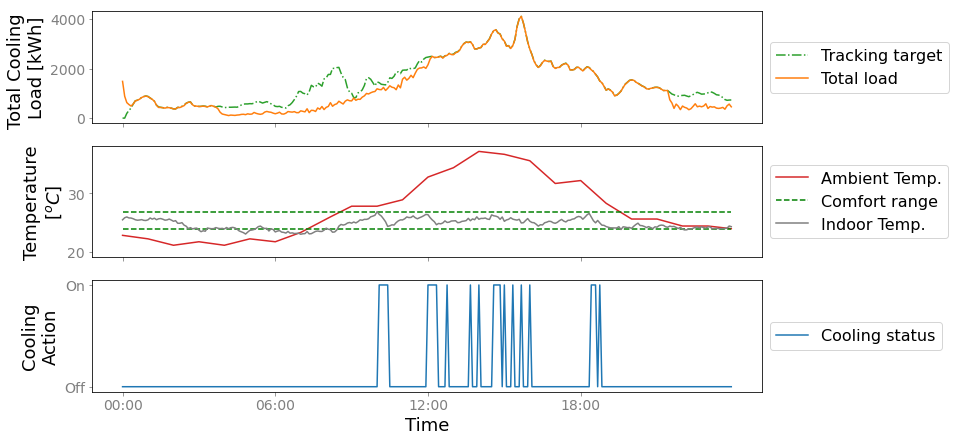

In [22]:
plot_household(T_in_coord_tracking, Action_coord_tracking, env, 3, 'psbc_tracking')

## ADMM

In [23]:
from util.admm import ControllerGroup, Aggregator, ADMM, g_tracking

In [24]:
SAMPLE_SIZE = 100  # Too slow to run 1000 households

np.random.seed(1)

env = residential.AlphaResEnv(sampleSize  = SAMPLE_SIZE, 
                           stepSize    = STEP_SIZE, 
                           simHorizon  = sim_horizon,
                           ambientWeather = weather_ts, 
                           ttc = ttc, 
                           teq = teq, 
                           tsp = tsp, 
                           trange = trange,
                           hvacMode = 'cooling only',
                           measurementErrorSigma = 0.2)

env_parameters = env.getParameters()

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float16
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [25]:
# get new power tracking targets
p_target,  _, _, _, _ = tracking_target(start_date, weather_ts[:24*12], env_parameters, teq, scale_factor=0.15)

In [26]:
## Pulse Width Modulation
# William Burke and David Auslander. 2009. Low-frequency pulse width modulation design for HVAC compressors. 
# In ASME 2009 International Design Engineering echnical Conferences and Computers and Information in 
# Engineering Conference. American Society of Mechanical Engineers Digital Collection, 291–297
def PWM(signal, cum_error, action, dt, limit=0.1):  
    '''
    signal: continuous control action, output of ADMM, [0, 1]
    cum_error: cumulative error, comparing cum_error with limit to change on/off
    action: discrete control action, input of environment 
    dt: control timestep, unit: hour
    limit: the threshold to change on/off
    '''
    pred_error = cum_error + (signal-action)*dt
    action = np.where(pred_error > limit, 1, action) # if pred_error > limit, change to on
    action = np.where(pred_error <-limit, 0, action) # if pred_error < -limit, change to off

    return action


In [27]:
T = 1 # Planning horizon
dt = 1/12 # Control timestep (Unit: Hour)
step_per_day = int(24/dt)
n_agent = SAMPLE_SIZE

rho = 10
eps = 1

In [28]:
param_df = env_parameters[['R','C','P_c','COP_c','T_sp','T_range']]
param_df.rename(columns={'P_c':'Pm','COP_c':'eta','T_sp':'theta','T_range':'Delta'}, inplace=True)
param_df['sign'] = -1

C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\walter\Anaconda3\envs\ecobee_env\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
## Initiate state and control variables
T = 1 # Planning horizon

## Initiate controller
controllers = ControllerGroup(T, dt, param_df) ## TCL-level Controllers
aggregator = Aggregator(T, g_tracking, [(T)], n_agent, rho) ## Load Aggregator

obs = env.reset()
x_init = obs[-n_agent:]
a_prev = np.zeros(n_agent*T).reshape(n_agent, T)
t_amb = weather_ts['Temperature'].values[0:T] + teq[0]*0.3   # solar heat gain must be 0
solHG_schd = env.get_solarHG_schd()

controllers.updateState(x_list = x_init, 
                        u_list = a_prev, 
                        d_list = np.tile(t_amb, (n_agent,1)))

# initiate dataframe to store results
T_in_ADMM = pd.DataFrame(index=env.t_index[:-1], columns = list(range(n_agent)))
Action_ADMM = pd.DataFrame(index=env.t_index[:-1], columns = list(range(n_agent))) # The On-Off action
Signal_ADMM = pd.DataFrame(index=env.t_index[:-1], columns = list(range(n_agent))) # The continuous solution

iter_list = [] # Number of iterations
cum_error = np.zeros(n_agent)  # for PWM

In [30]:
cur_idx = 0
energy_cum_prev = 0
while cur_idx < step_per_day:
    target = p_target[cur_idx:cur_idx+T]
    time = env.t_index[cur_idx]

    # Solve the coordination problem
    p_solution, n_iter = ADMM(controllers, aggregator, [target], eps, eps, v_init=np.mean(a_prev, axis =0)) # N x T
    iter_list.append(n_iter)
    
    u_solution = p_solution/env_parameters['P_c'].values[:,np.newaxis]
    signal = u_solution[:,0]
    action = PWM(signal, cum_error, a_prev[:,0], dt, limit=0.1)
    action = Override(action, x_init, env_parameters['T_sp'].values, env_parameters['T_range'])  
        # ganruatee comfort
    
    cum_error += (signal-action) * dt  # for PWM 
    
    obs,_,_,_ = env.step(action*2)
    x_indoor = obs[-n_agent:]
    
    T_in_ADMM.loc[time] = x_indoor
    Action_ADMM.loc[time] = action
    Signal_ADMM.loc[time] = signal
    
    # update the state of controller for the next time step
    cur_idx += 1
    t_amb = weather_ts['Temperature'].values[cur_idx:cur_idx+T] + \
        teq[0]*0.3 + teq[0]*0.7*(1-weather_ts['CloudCoverage'].values[cur_idx:cur_idx+T]/100)*solHG_schd[time.hour]
    
    a_prev = np.tile(action.reshape(n_agent, 1), (1, T))
    controllers.updateState(x_list = x_indoor, 
                            u_list = a_prev, 
                            d_list = np.tile(t_amb, (n_agent,1)))
    
    energy = (action*env_parameters['P_c'].values).sum()
    # from utils.plot import plotDensity, plotStepprint(action)
    print("T = {}, Num. Of Iter. = {}".format(cur_idx, n_iter))
    print("Target = {}, Actual = {}".format(target, energy))
        

T = 1, Num. Of Iter. = 1
Target = [0.], Actual = 0.0
T = 2, Num. Of Iter. = 1
Target = [0.], Actual = 0.0
T = 3, Num. Of Iter. = 3
Target = [17.50825101], Actual = 0.0
T = 4, Num. Of Iter. = 4
Target = [28.98955179], Actual = 0.0
T = 5, Num. Of Iter. = 4
Target = [38.90813592], Actual = 0.0
T = 6, Num. Of Iter. = 4
Target = [54.67742272], Actual = 0.0
T = 7, Num. Of Iter. = 4
Target = [67.95945852], Actual = 0.0
T = 8, Num. Of Iter. = 4
Target = [70.24692003], Actual = 2.020341418061776
T = 9, Num. Of Iter. = 4
Target = [74.37305383], Actual = 12.376446915612163
T = 10, Num. Of Iter. = 4
Target = [81.31523436], Actual = 32.765478737274016
T = 11, Num. Of Iter. = 4
Target = [84.93731277], Actual = 40.70719285019625
T = 12, Num. Of Iter. = 4
Target = [87.2328811], Actual = 66.41052312517951
T = 13, Num. Of Iter. = 4
Target = [85.45318255], Actual = 104.22806452893681
T = 14, Num. Of Iter. = 7
Target = [79.23345624], Actual = 104.22806452893681
T = 15, Num. Of Iter. = 7
Target = [73.94186

15 infeasible
35 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
15 infeasible
35 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
15 infeasible
35 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
T = 39, Num. Of Iter. = 4
Target = [47.1875682], Actual = 43.54857001375532
15 infeasible
20 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
15 infeasible
20 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
15 infeasible
20 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible
54 infeasible
57 infeasible
78 infeasible
91 infeasible
15 infeasible
20 infeasible
37 infeasible
39 infeasible
40 infeasible
51 infeasible


15 infeasible
23 infeasible
24 infeasible
35 infeasible
37 infeasible
39 infeasible
47 infeasible
48 infeasible
51 infeasible
54 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
90 infeasible
91 infeasible
15 infeasible
23 infeasible
24 infeasible
35 infeasible
37 infeasible
39 infeasible
47 infeasible
48 infeasible
51 infeasible
54 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
90 infeasible
91 infeasible
T = 50, Num. Of Iter. = 2
Target = [42.05932394], Actual = 44.13834408711101
15 infeasible
20 infeasible
23 infeasible
24 infeasible
33 infeasible
34 infeasible
35 infeasible
37 infeasible
39 infeasible
47 infeasible
48 infeasible
51 infeasible
54 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
89 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
33 infeasible
34 infeasible
35 infeasible
37 infeasible
39 infeasible
47 infeasible
48 infeasible
51 infeasible
54 infeasible
57 infeasible

15 infeasible
23 infeasible
24 infeasible
33 infeasible
35 infeasible
37 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
89 infeasible
90 infeasible
91 infeasible
T = 59, Num. Of Iter. = 5
Target = [55.46392876], Actual = 46.60247995984002
15 infeasible
23 infeasible
24 infeasible
33 infeasible
35 infeasible
37 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
89 infeasible
90 infeasible
91 infeasible
15 infeasible
23 infeasible
24 infeasible
33 infeasible
35 infeasible
37 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
89 infeasible
90 infeasible
91 infeasible
15 infeasible
23 infeasible
24 infeasible
33 infeasible
35 infeasible
37 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
78 infeasible
85 infeasible
89 infeasible

78 infeasible
79 infeasible
85 infeasible
86 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible
86 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible
86 infeasible
90 infeasible
91 infeasible
T = 65, Num. Of Iter. = 5
Target = [66.3768781], Actual = 77.41360862012706
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible


15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible
88 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible
88 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
47 infeasible
48 infeasible
51 infeasible
57 infeasible
60 infeasible
77 infeasible
78 infeasible
79 infeasible
85 infeasible
88 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
27 inf

17 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
32 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
91 infeasible
17 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
32 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
91 infeasible
17 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
32 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
91 infeasible
17 infeasible
23 infeasible
24 infeasible
26 infeasible
27 infeasible
32 infeasible
33 infeasible
34 infeasible
35 infeasible
40 infeasible
48 infeasible
51 infeasible
57 infeasible
77 infeasible
79 inf

91 infeasible
15 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
51 infeasible
57 infeasible
68 infeasible
79 infeasible
85 infeasible
88 infeasible
91 infeasible
15 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
51 infeasible
57 infeasible
68 infeasible
79 infeasible
85 infeasible
88 infeasible
91 infeasible
15 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
51 infeasible
57 infeasible
68 infeasible
79 infeasible
85 infeasible
88 infeasible
91 infeasible
15 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
51 infeasible
57 infeasible
68 infeasible
79 infeasible
85 infeasible
88 infeasible
91 infeasible
15 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 inf

15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
33 infeasible
40 infeasible
46 infeasible
47 infeasible
57 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
90 infeasible
91 infeasible
T = 80, Num. Of Iter. = 5
Target = [52.2047966], Actual = 48.4018665913343
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
46 infeasible
47 infeasible
57 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
46 infeasible
47 infeasible
57 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
90 infeasible
91 infeasible
15 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
33 infeasible
40 infeasible
46 infeasible
47 infeasible
57 infeasible
79 infeasible
85 infeasible
86 infeasible
88 infeasible
90 infeasible
9

78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
13 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
33 infeasible
39 infeasible
40 infeasible
47 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
13 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
33 infeasible
39 infeasible
40 infeasible
47 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
T = 86, Num. Of Iter. = 5
Target = [98.24834084], Actual = 115.39544403023939
13 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
33 infeasible
39 infeasible
40 infeasible
47 infeasible
57 infeasible
62 infeasible
78 infeasible
79 infeasible
87 infeasible
88 infeasible
90 infeasible
91 infeasible
13 infeasible
17 infeasible
20 infeasible
23 infeasible
24 infeasible
26 infeasible
33 infeasible
39 infeasible
40 infeasible
47 infeasible
57 infeasible
62 infeasible
78 infeasibl

17 infeasible
20 infeasible
24 infeasible
26 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
48 infeasible
53 infeasible
57 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
17 infeasible
20 infeasible
24 infeasible
26 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
48 infeasible
53 infeasible
57 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
17 infeasible
20 infeasible
24 infeasible
26 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
48 infeasible
53 infeasible
57 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 infeasible
17 infeasible
20 infeasible
24 infeasible
26 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
48 infeasible
53 infeasible
57 infeasible
78 infeasible
79 infeasible
88 infeasible
90 infeasible
91 inf

17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
27 infeasible
28 infeasible
32 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
47 infeasible
53 infeasible
58 infeasible
60 infeasible
69 infeasible
78 infeasible
79 infeasible
90 infeasible
91 infeasible
7 infeasible
17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
27 infeasible
28 infeasible
32 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
47 infeasible
53 infeasible
58 infeasible
60 infeasible
69 infeasible
78 infeasible
79 infeasible
90 infeasible
91 infeasible
7 infeasible
17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
27 infeasible
28 infeasible
32 infeasible
33 infeasible
34 infeasible
39 infeasible
40 infeasible
47 infeasible
53 infeasible
58 infeasible
60 infeasible
69 infeasible
78 infeasible
79 infeasible
90 infeasible
91 infeasible
T = 97, Num. Of Iter. = 7
Target = [158.14907125], Actual = 168.06513237010574
7 infeasible


90 infeasible
91 infeasible
99 infeasible
10 infeasible
17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
28 infeasible
33 infeasible
34 infeasible
35 infeasible
39 infeasible
40 infeasible
47 infeasible
53 infeasible
58 infeasible
60 infeasible
69 infeasible
73 infeasible
78 infeasible
79 infeasible
80 infeasible
90 infeasible
91 infeasible
99 infeasible
10 infeasible
17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
28 infeasible
33 infeasible
34 infeasible
35 infeasible
39 infeasible
40 infeasible
47 infeasible
53 infeasible
58 infeasible
60 infeasible
69 infeasible
73 infeasible
78 infeasible
79 infeasible
80 infeasible
90 infeasible
91 infeasible
99 infeasible
T = 100, Num. Of Iter. = 9
Target = [196.60308451], Actual = 187.74843143991137
10 infeasible
17 infeasible
19 infeasible
20 infeasible
24 infeasible
26 infeasible
28 infeasible
30 infeasible
32 infeasible
34 infeasible
35 infeasible
39 infeasible
40 infeasible
47 infeasible
48 infeasi

7 infeasible
10 infeasible
11 infeasible
15 infeasible
17 infeasible
19 infeasible
24 infeasible
26 infeasible
28 infeasible
30 infeasible
32 infeasible
34 infeasible
39 infeasible
40 infeasible
48 infeasible
51 infeasible
53 infeasible
54 infeasible
58 infeasible
60 infeasible
68 infeasible
69 infeasible
73 infeasible
78 infeasible
79 infeasible
80 infeasible
81 infeasible
90 infeasible
91 infeasible
7 infeasible
10 infeasible
11 infeasible
15 infeasible
17 infeasible
19 infeasible
24 infeasible
26 infeasible
28 infeasible
30 infeasible
32 infeasible
34 infeasible
39 infeasible
40 infeasible
48 infeasible
51 infeasible
53 infeasible
54 infeasible
58 infeasible
60 infeasible
68 infeasible
69 infeasible
73 infeasible
78 infeasible
79 infeasible
80 infeasible
81 infeasible
90 infeasible
91 infeasible
7 infeasible
10 infeasible
11 infeasible
15 infeasible
17 infeasible
19 infeasible
24 infeasible
26 infeasible
28 infeasible
30 infeasible
32 infeasible
34 infeasible
39 infeasible
40 infeas

45 infeasible
48 infeasible
53 infeasible
58 infeasible
68 infeasible
69 infeasible
73 infeasible
74 infeasible
75 infeasible
77 infeasible
78 infeasible
79 infeasible
80 infeasible
81 infeasible
90 infeasible
91 infeasible
3 infeasible
7 infeasible
10 infeasible
15 infeasible
17 infeasible
19 infeasible
24 infeasible
26 infeasible
28 infeasible
31 infeasible
34 infeasible
39 infeasible
40 infeasible
45 infeasible
48 infeasible
53 infeasible
58 infeasible
68 infeasible
69 infeasible
73 infeasible
74 infeasible
75 infeasible
77 infeasible
78 infeasible
79 infeasible
80 infeasible
81 infeasible
90 infeasible
91 infeasible
3 infeasible
7 infeasible
10 infeasible
15 infeasible
17 infeasible
19 infeasible
24 infeasible
26 infeasible
28 infeasible
31 infeasible
34 infeasible
39 infeasible
40 infeasible
45 infeasible
48 infeasible
53 infeasible
58 infeasible
68 infeasible
69 infeasible
73 infeasible
74 infeasible
75 infeasible
77 infeasible
78 infeasible
79 infeasible
80 infeasible
81 infeasi

74 infeasible
79 infeasible
81 infeasible
90 infeasible
91 infeasible
99 infeasible
10 infeasible
17 infeasible
19 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
35 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
53 infeasible
59 infeasible
60 infeasible
68 infeasible
74 infeasible
79 infeasible
81 infeasible
90 infeasible
91 infeasible
99 infeasible
10 infeasible
17 infeasible
19 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
35 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
53 infeasible
59 infeasible
60 infeasible
68 infeasible
74 infeasible
79 infeasible
81 infeasible
90 infeasible
91 infeasible
99 infeasible
10 infeasible
17 infeasible
19 infeasible
23 infeasible
24 infeasible
26 infeasible
32 infeasible
35 infeasible
39 infeasible
40 infeasible
44 infeasible
47 infeasible
53 infeasible
59 infeasible
60 infeasible
68 infeasible
74 infeasible
79 infeasible
81 infeasible
90 infeasible
91 infeasible
99 inf

24 infeasible
26 infeasible
27 infeasible
37 infeasible
38 infeasible
39 infeasible
47 infeasible
53 infeasible
59 infeasible
60 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
90 infeasible
91 infeasible
93 infeasible
T = 115, Num. Of Iter. = 7
Target = [127.01985506], Actual = 85.58763972310769
2 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
37 infeasible
38 infeasible
39 infeasible
47 infeasible
53 infeasible
59 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 infeasible
93 infeasible
2 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
37 infeasible
38 infeasible
39 infeasible
47 infeasible
53 infeasible
59 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 infeasible
93 infeasible
2 infeasible
24 infeasible
26 infeasible
27 infeasible
33 infeasible
37 infeasible
38 infeasible
39 infeasible
47 infeasible
53 infeasible
59 infeasible


19 infeasible
37 infeasible
38 infeasible
39 infeasible
45 infeasible
47 infeasible
53 infeasible
55 infeasible
59 infeasible
62 infeasible
72 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 infeasible
19 infeasible
37 infeasible
38 infeasible
39 infeasible
45 infeasible
47 infeasible
53 infeasible
55 infeasible
59 infeasible
62 infeasible
72 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 infeasible
19 infeasible
37 infeasible
38 infeasible
39 infeasible
45 infeasible
47 infeasible
53 infeasible
55 infeasible
59 infeasible
62 infeasible
72 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 infeasible
19 infeasible
37 infeasible
38 infeasible
39 infeasible
45 infeasible
47 infeasible
53 infeasible
55 infeasible
59 infeasible
62 infeasible
72 infeasible
77 infeasible
79 infeasible
81 infeasible
87 infeasible
89 infeasible
90 infeasible
91 inf

37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 infeasible
37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 infeasible
37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 infeasible
37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 infeasible
37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 infeasible
37 infeasible
39 infeasible
47 infeasible
55 infeasible
59 infeasible
62 infeasible
77 infeasible
79 infeasible
87 infeasible
88 infeasible
91 infeasible
96 inf

32 infeasible
39 infeasible
47 infeasible
59 infeasible
T = 140, Num. Of Iter. = 5
Target = [212.75433148], Actual = 221.17070125972052
0 infeasible
39 infeasible
47 infeasible
59 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
59 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
59 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
59 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
59 infeasible
66 infeasible
T = 141, Num. Of Iter. = 5
Target = [225.31322767], Actual = 230.87935225822255
0 infeasible
39 infeasible
47 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
66 infeasible
0 infeasible
39 infeasible
47 infeasible
66 infeasible
T = 142, Num. Of Iter. = 5
Target = [219.49120557], Actual = 238.77376302030277
0 infeasible
39 infeasible
47 infeasible
66 infeasible
0 infeasible
39 infeasible
47

61 infeasible
85 infeasible
94 infeasible
47 infeasible
61 infeasible
85 infeasible
94 infeasible
47 infeasible
61 infeasible
85 infeasible
94 infeasible
T = 162, Num. Of Iter. = 5
Target = [292.55843641], Actual = 285.9407261219785
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
T = 163, Num. Of Iter. = 6
Target = [298.28039955], Actual = 297.96632870182805
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
89 infeasible
30 infeasible
47 infeasible
61 infeasible
85 infeasible
8

74 infeasible
T = 191, Num. Of Iter. = 5
Target = [337.690307], Actual = 474.58501558716586
51 infeasible
74 infeasible
95 infeasible
51 infeasible
74 infeasible
95 infeasible
51 infeasible
74 infeasible
95 infeasible
51 infeasible
74 infeasible
95 infeasible
51 infeasible
74 infeasible
95 infeasible
T = 192, Num. Of Iter. = 5
Target = [299.04792471], Actual = 316.7019298620945
74 infeasible
95 infeasible
74 infeasible
95 infeasible
74 infeasible
95 infeasible
74 infeasible
95 infeasible
74 infeasible
95 infeasible
T = 193, Num. Of Iter. = 5
Target = [270.54238904], Actual = 224.995825767947
15 infeasible
95 infeasible
15 infeasible
95 infeasible
15 infeasible
95 infeasible
15 infeasible
95 infeasible
15 infeasible
95 infeasible
T = 194, Num. Of Iter. = 5
Target = [248.64709729], Actual = 224.35375076927414
0 infeasible
15 infeasible
95 infeasible
0 infeasible
15 infeasible
95 infeasible
0 infeasible
15 infeasible
95 infeasible
0 infeasible
15 infeasible
95 infeasible
0 infeasible
15 i

0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
0 infeasible
4 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
T = 214, Num. Of Iter. = 6
Target = [190.06215414], Actual = 196.6293793713923
0 infeasible
19 infeasible
21 infeasible
32 infeasible
47 infeasible
57 infeasible
85 infeasi

74 infeasible
80 infeasible
85 infeasible
89 infeasible
4 infeasible
17 infeasible
19 infeasible
40 infeasible
41 infeasible
42 infeasible
57 infeasible
74 infeasible
80 infeasible
85 infeasible
89 infeasible
4 infeasible
17 infeasible
19 infeasible
40 infeasible
41 infeasible
42 infeasible
57 infeasible
74 infeasible
80 infeasible
85 infeasible
89 infeasible
T = 227, Num. Of Iter. = 7
Target = [138.06184208], Actual = 156.73193389443122
17 infeasible
19 infeasible
40 infeasible
42 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
89 infeasible
17 infeasible
19 infeasible
40 infeasible
42 infeasible
51 infeasible
57 infeasible
74 infeasible
85 infeasible
89 infeasible
T = 228, Num. Of Iter. = 2
Target = [124.07845433], Actual = 142.37442682723912
4 infeasible
17 infeasible
19 infeasible
29 infeasible
39 infeasible
40 infeasible
42 infeasible
51 infeasible
57 infeasible
89 infeasible
4 infeasible
17 infeasible
19 infeasible
29 infeasible
39 infeasible
40 infeasible
42 i

31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
0 infeasible
2 infeasible
4 infeasible
8 infeasible
17 infeasible
24 infeasible
31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
0 infeasible
2 infeasible
4 infeasible
8 infeasible
17 infeasible
24 infeasible
31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
0 infeasible
2 infeasible
4 infeasible
8 infeasible
17 infeasible
24 infeasible
31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
0 infeasible
2 infeasible
4 infeasible
8 infeasible
17 infeasible
24 infeasible
31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
0 infeasible
2 infeasible
4 infeasible
8 infeasible
17 infeasible
24 infeasible
31 infeasible
42 infeasible
51 infeasible
61 infeasible
80 infeasible
89 infeasible
T = 239, Num. Of Iter. = 6
Target = [140.87253091], Actual = 151.83573169868498
0 infeasible
4 i

42 infeasible
44 infeasible
51 infeasible
54 infeasible
57 infeasible
60 infeasible
61 infeasible
74 infeasible
80 infeasible
81 infeasible
99 infeasible
T = 246, Num. Of Iter. = 5
Target = [126.12699328], Actual = 137.97072277100472
0 infeasible
4 infeasible
17 infeasible
36 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
80 infeasible
81 infeasible
85 infeasible
89 infeasible
0 infeasible
4 infeasible
17 infeasible
36 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
80 infeasible
81 infeasible
85 infeasible
89 infeasible
0 infeasible
4 infeasible
17 infeasible
36 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
80 infeasible
81 infeasible
85 infeasible
89 infeasible
0 infeasible
4 infeasible
17 infeasible
36 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 i

60 infeasible
61 infeasible
63 infeasible
74 infeasible
77 infeasible
95 infeasible
0 infeasible
4 infeasible
21 infeasible
31 infeasible
34 infeasible
42 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
77 infeasible
95 infeasible
0 infeasible
4 infeasible
21 infeasible
31 infeasible
34 infeasible
42 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
77 infeasible
95 infeasible
T = 255, Num. Of Iter. = 5
Target = [113.56938523], Actual = 111.97803799107054
0 infeasible
31 infeasible
34 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
77 infeasible
79 infeasible
90 infeasible
95 infeasible
0 infeasible
31 infeasible
34 infeasible
42 infeasible
51 infeasible
58 infeasible
60 infeasible
61 infeasible
63 infeasible
74 infeasible
77 infeasible
79 infeasible
90 infeasible
95 infeasible
0 infeasible
31 infeasible
34 infeasible
42 infeasible
51 infeasible
58 infeasible
60 

21 infeasible
24 infeasible
31 infeasible
34 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
61 infeasible
69 infeasible
77 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
21 infeasible
24 infeasible
31 infeasible
34 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
61 infeasible
69 infeasible
77 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
21 infeasible
24 infeasible
31 infeasible
34 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
61 infeasible
69 infeasible
77 infeasible
90 infeasible
95 infeasible
99 infeasible
T = 262, Num. Of Iter. = 13
Target = [86.71963803], Actual = 43.24593272394359
0 infeasible
21 infeasible
24 infeasible
31 infeasible
34 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
61 infeasible
69 infeasible
77 infeasible
85 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
21 infeasible
24 infeasible
31 infeasible
34 infeasible
50 infeasible
5

90 infeasible
95 infeasible
99 infeasible
T = 268, Num. Of Iter. = 5
Target = [83.59650491], Actual = 61.127125665767096
0 infeasible
4 infeasible
24 infeasible
36 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
88 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
4 infeasible
24 infeasible
36 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
88 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
4 infeasible
24 infeasible
36 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
88 infeasible
90 infeasible
95 infeasible
99 infeasible
0 infeasible
4 infeasible
24 infeasible
36 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 in

19 infeasible
24 infeasible
34 infeasible
40 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
66 infeasible
74 infeasible
95 infeasible
99 infeasible
T = 274, Num. Of Iter. = 5
Target = [93.79981455], Actual = 93.09836992773052
24 infeasible
34 infeasible
40 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
66 infeasible
74 infeasible
90 infeasible
91 infeasible
95 infeasible
99 infeasible
24 infeasible
34 infeasible
40 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
66 infeasible
74 infeasible
90 infeasible
91 infeasible
95 infeasible
99 infeasible
24 infeasible
34 infeasible
40 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
66 infeasible
74 infeasible
90 infeasible
91 infeasible
95 infeasible
99 infeasible
24 infeasible
34 infeasible
40 infeasible
45 infeasibl

24 infeasible
33 infeasible
39 infeasible
50 infeasible
51 infeasible
54 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
62 infeasible
66 infeasible
74 infeasible
79 infeasible
82 infeasible
91 infeasible
92 infeasible
95 infeasible
99 infeasible
24 infeasible
33 infeasible
39 infeasible
50 infeasible
51 infeasible
54 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
62 infeasible
66 infeasible
74 infeasible
79 infeasible
82 infeasible
91 infeasible
92 infeasible
95 infeasible
99 infeasible
24 infeasible
33 infeasible
39 infeasible
50 infeasible
51 infeasible
54 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
62 infeasible
66 infeasible
74 infeasible
79 infeasible
82 infeasible
91 infeasible
92 infeasible
95 infeasible
99 infeasible
24 infeasible
33 infeasible
39 infeasible
50 infeasible
51 infeasible
54 infeasible
55 infeasible
58 infeasible
59 infeasible
60 infeasible
61 infeasible
62 inf

95 infeasible
99 infeasible
7 infeasible
24 infeasible
33 infeasible
37 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
61 infeasible
66 infeasible
79 infeasible
81 infeasible
91 infeasible
95 infeasible
99 infeasible
7 infeasible
24 infeasible
33 infeasible
37 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
61 infeasible
66 infeasible
79 infeasible
81 infeasible
91 infeasible
95 infeasible
99 infeasible
7 infeasible
24 infeasible
33 infeasible
37 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
61 infeasible
66 infeasible
79 infeasible
81 infeasible
91 infeasible
95 infeasible
99 infeasible
7 infeasible
24 infeasible
33 infeasible
37 infeasible
42 infeasible
45 infeasible
50 infeasible
51 infeasible
58 infeasible
61 infeasible
66 infeasible
79 infeasible
81 infeasible
91 infeasible
95 infeasible
99 infeasible
Episode: 1
Total Energy Consumption (kWh)
3356.7984702110234
Total Uncomfortable

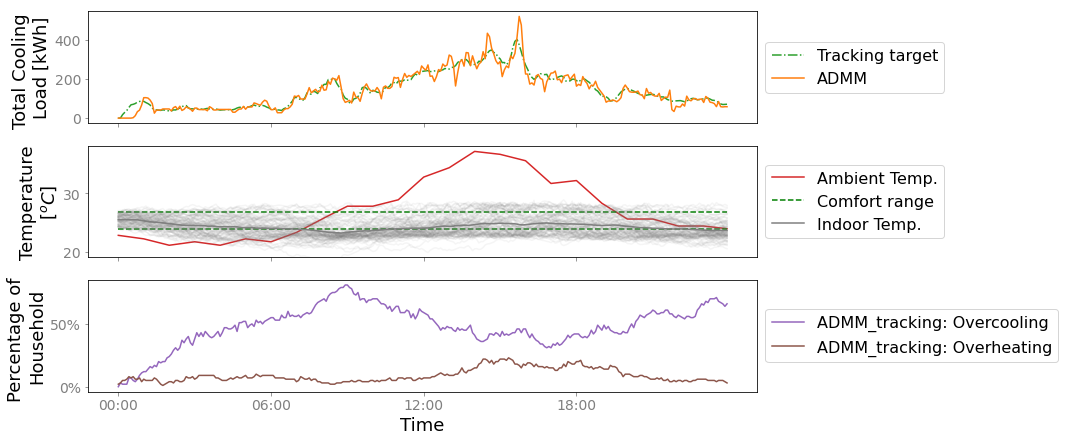

In [31]:
fig, axes = plt.subplots(3,1, figsize=(12, 7), sharex=True)

time_index = T_in_ADMM.index

# subplot1: total cooling load
q_c_coord = (Action_ADMM.values * env_parameters['P_c'].values).sum(axis=1)
axes[0].plot(time_index, p_target, '-.', color=default_colors[2], label='Tracking target')
axes[0].plot(time_index, q_c_coord, color=default_colors[1], label='ADMM')
axes[0].set_ylabel('Total Cooling \nLoad [kWh]')
axes[0].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot2: ambient temperature
axes[1].plot(time_index, weather_ts['Temperature'].values[:len(time_index)], color=default_colors[3], label='Ambient Temp.')
# plot deadband
t_lower = tsp[0] - trange[0]/2
t_upper = tsp[0] + trange[0]/2
axes[1].plot((time_index[0],time_index[-1]), (t_lower, t_lower), 'g--', label='Comfort range')
axes[1].plot((time_index[0],time_index[-1]), (t_upper, t_upper), 'g--')
# plot temperature
axes[1].plot(time_index, T_in_ADMM.values.mean(axis=1), 'grey', label='Indoor Temp.')
for columns in T_in_ADMM:
    axes[1].plot(time_index, T_in_ADMM[columns].values, 'grey', alpha=0.08)
axes[1].set_ylabel('Temperature\n[$^oC$]')
axes[1].set_ylim(weather_ts['Temperature'].values.min()-1, weather_ts['Temperature'].values.max()+1)
axes[1].legend(loc='center left', bbox_to_anchor=(1,0.5))

# subplot3: percentage of discomfort
overcooling_coord = (T_in_ADMM < t_lower).mean(axis=1).values
overheating_coord = (T_in_ADMM > t_upper).mean(axis=1).values
# overcooling_conv = (T_in_conv < t_lower).mean(axis=1).values
# overheating_conv = (T_in_conv > t_upper).mean(axis=1).values
# axes[2].plot(time_index, overcooling_conv, '--',color=default_colors[4], label = 'RBC: Overcooling')
# axes[2].plot(time_index, overheating_conv, '--',color=default_colors[5], label = 'RBC Overheating')
axes[2].plot(time_index, overcooling_coord, color=default_colors[4], label = 'ADMM_tracking: Overcooling')
axes[2].plot(time_index, overheating_coord, color=default_colors[5], label = 'ADMM_tracking: Overheating')
axes[2].set_ylabel('Percentage of \nHousehold')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
axes[2].legend(loc='center left', bbox_to_anchor=(1,0.5))

axes[2].set_xlabel('Time')
axes[2].set_xticks(time_index[::72])
myFmt = mdates.DateFormatter('%H:%M')
axes[2].xaxis.set_major_formatter(myFmt)

plt.savefig(generate_fig_name('ADMM_tracking'))

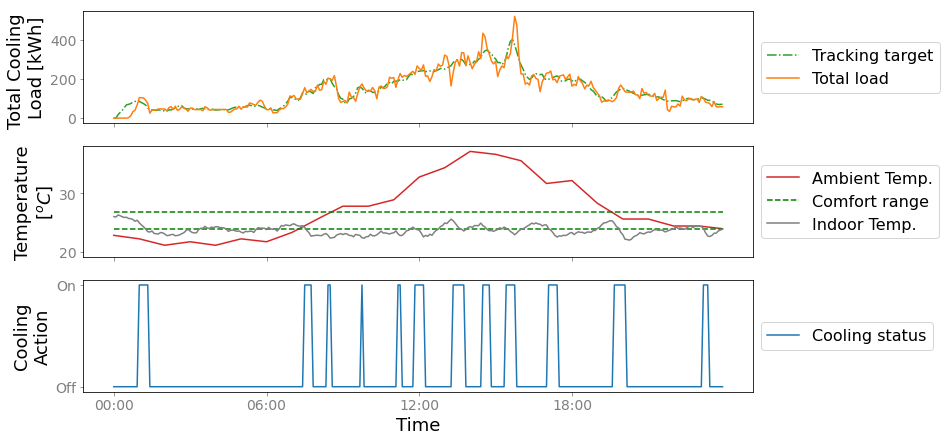

In [32]:
plot_household(T_in_ADMM, Action_ADMM, env, 3, 'admm')

## Compare comfort

In [33]:
def calculate_deviation(t_in, t_upper, t_lower):
    t_in = t_in.values.flatten()
    t_in_dev = np.where(t_in > t_upper, t_in-t_upper, 0)
    t_in_dev = np.where(t_in < t_lower, t_in-t_lower, t_in_dev)
    return t_in_dev

In [34]:
T_in_coord_shedding_del = calculate_deviation(T_in_coord_shedding, t_upper, t_lower)
T_in_coord_tracking_del = calculate_deviation(T_in_coord_tracking, t_upper, t_lower)
T_in_ADMM_tracking_del = calculate_deviation(T_in_ADMM, t_upper, t_lower)
T_in_conv_del = calculate_deviation(T_in_conv, t_upper, t_lower)

In [35]:
psbc_shed = (T_in_coord_shedding_del>0).sum()/len(T_in_coord_shedding_del)
psbc_track = (T_in_coord_tracking_del>0).sum()/len(T_in_coord_tracking_del)
admm_track = (T_in_ADMM_tracking_del>0).sum()/len(T_in_ADMM_tracking_del)
rbc = (T_in_conv_del>0).sum()/len(T_in_conv_del)

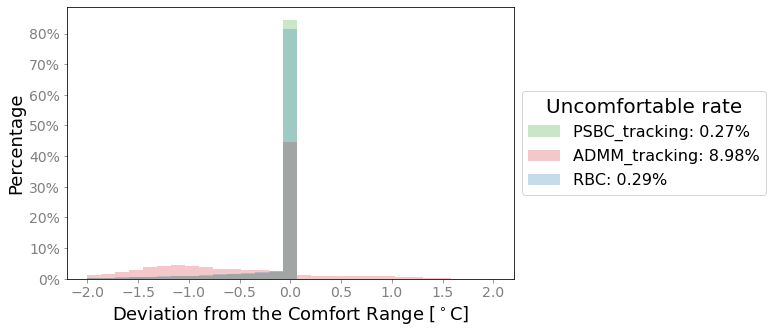

In [36]:
bins = np.linspace(-2,2,30)
alpha = 0.25

plt.figure(figsize=(8,5))
# plt.hist(T_in_coord_shedding_del, bins, alpha=alpha, label='PSBC_shedding: {:.2%}'.format(psbc_shed), 
#          color=default_colors[1], weights=np.ones(len(T_in_coord_shedding_del))/len(T_in_coord_shedding_del))
plt.hist(T_in_coord_tracking_del, bins, alpha=alpha, label='PSBC_tracking: {:.2%}'.format(psbc_track), 
         color=default_colors[2], weights=np.ones(len(T_in_coord_tracking_del))/len(T_in_coord_tracking_del))
plt.hist(T_in_ADMM_tracking_del, bins, alpha=alpha, label='ADMM_tracking: {:.2%}'.format(admm_track), 
         color=default_colors[3], weights=np.ones(len(T_in_ADMM_tracking_del))/len(T_in_ADMM_tracking_del))
plt.hist(T_in_conv_del, bins, alpha=alpha, label='RBC: {:.2%}'.format(rbc), 
         color=default_colors[0], weights=np.ones(len(T_in_conv_del))/len(T_in_conv_del))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),title="Uncomfortable rate")
plt.xlabel('Deviation from the Comfort Range [$^\circ$C]')
plt.ylabel('Percentage')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

plt.savefig(generate_fig_name('comfort compare'))